In [72]:
import os
import sys
import time
import pickle

from os import listdir
from os.path import isfile, join

from functools import partial

import pandas as pd
import numpy as np

from multiprocessing import Pool

from sklearn.datasets import load_digits

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_adaptive

from script.image import load_train_gray_resized

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
print("Tensorflow is installed and is version: ",  tf.__version__)

%matplotlib inline

Tensorflow is installed and is version:  1.3.0


#### Load the labels

In [2]:
labels_df = pd.read_csv('labels.csv')
print(labels_df.shape)

(10222, 2)


In [3]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
breeds = labels_df.breed.unique()
print('Total of %d unique breeds' % len(breeds))
print('-------------------------')
print(breeds)

Total of 120 unique breeds
-------------------------
['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier' 'kuvasz'
 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 '

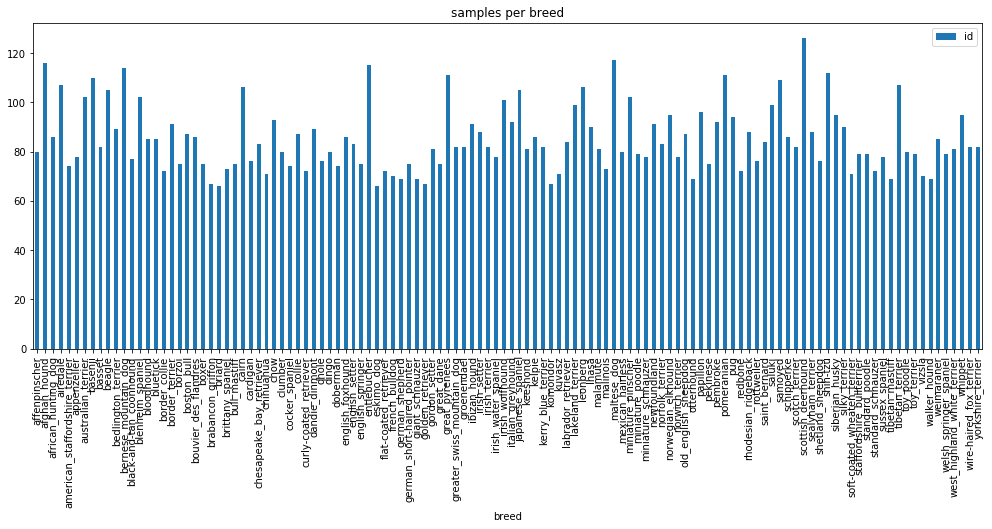

In [5]:
p = labels_df.groupby('breed').count().plot.bar(title='samples per breed', figsize=(17, 6))

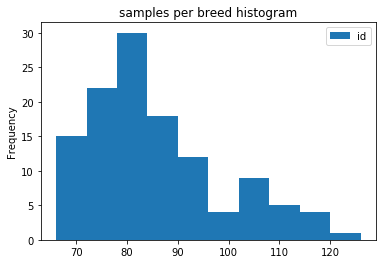

In [6]:
p = labels_df.groupby('breed').count().plot.hist(title='samples per breed histogram')

it looks like we have a balanced dataset, most of the breeds represented by 80 samples with some represented with as many as 120 and some as less as 70.

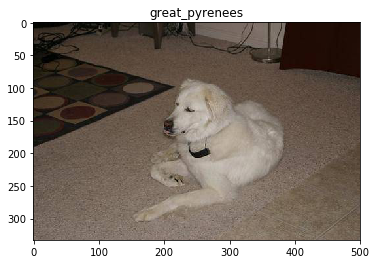

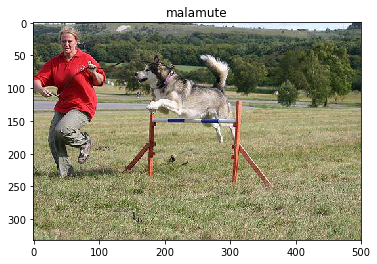

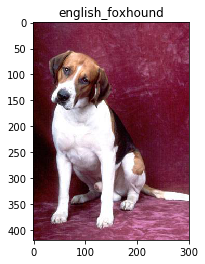

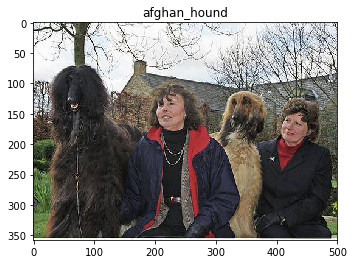

In [7]:
sample_df = labels_df.sample(4, random_state = 102)

for index, row in sample_df.iterrows():
    plt.figure()
    img=mpimg.imread('train/' + row['id'] + '.jpg')
    imgplot=plt.imshow(img)
    plt.title(row['breed'])

1. Some images have multiple dogs.
2. Some images have people and other objects.
3. Some images are different sizes.

#### Can we reduce the image size without loosing too much information?

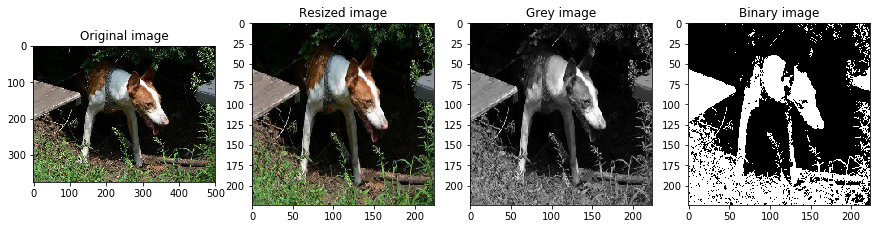

In [8]:
fig, ax= plt.subplots(nrows=1, ncols=4, figsize = (15, 6))

img = io.imread('train/00ddcec076073cc96f82c27bf4548fbc.jpg')
ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title("Original image")

img_resized = resize(img, (224, 224), mode  = 'reflect')
ax[1].imshow(img_resized, cmap=plt.cm.gray)
ax[1].set_title("Resized image")

img_gray = rgb2gray(img_resized)
ax[2].imshow(img_gray, cmap=plt.cm.gray)
ax[2].set_title("Grey image")

thresh = threshold_otsu(img_gray)
binary = img_gray > thresh

ax[3].imshow(binary, cmap=plt.cm.gray)
ax[3].set_title("Binary image")

The grey version looks reasonable, the binary version might be OK to recoginze a dog but probably not a breed.

Load images

In [9]:
def load_images(folder, names, h, w):
    load_image = partial(load_train_gray_resized, folder=folder, h=h, w=w)
    
    with Pool(6) as p:
        rs = p.map_async(load_image, names)
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)
    print('Finished loading images...')
    
    images = []
    for r in rs.get():
        images.append(r)
    return np.asarray(images)

In [10]:
train_ids = list(labels_df.id)
train_features = load_images('train', train_ids, 224, 224)
print('Features shape ', train_features.shape)

Waiting for 24 tasks to complete...
Waiting for 19 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 7 tasks to complete...
Waiting for 1 tasks to complete...
Finished loading images...
Features shape  (10222, 224, 224)


In [73]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels_df.breed)
print('Labels shape ', labels.shape)

Labels shape  (10222, 120)


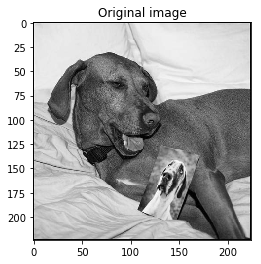

In [12]:
plt.imshow(train_features[100], cmap='gray')
plt.title('Original image')

In [13]:
train_features_mean = np.mean(train_features, axis=(0))
print(train_features_mean.shape)

(224, 224)


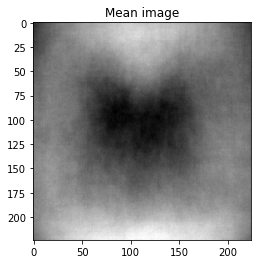

In [14]:
plt.imshow(train_features_mean, cmap='gray')
plt.title('Mean image')

In [15]:
train_features_centered = train_features - train_features_mean

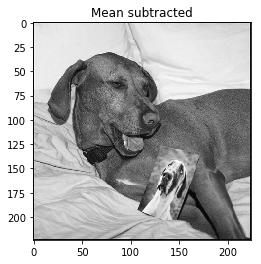

In [16]:
plt.imshow(train_features_centered[100], cmap='gray')
plt.title('Mean subtracted')

In [17]:
train_features_flat = train_features_centered.reshape(10222, -1)
print(train_features_flat.shape)

(10222, 50176)


In [18]:
F_train, F_test, l_train, l_test = train_test_split(
    train_features_flat, labels, test_size=0.20, stratify = labels_df.breed, random_state = 442)

In [19]:
print('Train label matrix shape:', l_train.shape)
print('Train predictor matrix shape:', F_train.shape)
print('Test label matrix shape:', l_test.shape)
print('Test predictor matrix shape:', F_test.shape)

Train label matrix shape: (8177, 120)
Train predictor matrix shape: (8177, 50176)
Test label matrix shape: (2045, 120)
Test predictor matrix shape: (2045, 50176)


In [20]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [21]:
def plot_results(losses, train_acc, valid_acc, test_acc):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_ylabel('loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.plot(losses, 'b:')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params('y', colors='r')
    ax2.plot(train_acc, 'r--', label='train')
    ax2.plot(valid_acc, 'r-', label='valid')
    ax2.legend(loc=0)

    plt.title('test accuracy is {:.2%}'.format(test_acc/100.))

    fig.tight_layout()

Base class for a neural network

In [22]:
class NN(object):
    def __init__(self, features_size, labels_size):
        
        self.loss = None
        self.optimizer = None
        self.train_prediction = None
        self.test_prediction = None

        tf.reset_default_graph()
        tf.set_random_seed(100)
        np.random.seed(100)
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            # create input variables
            self.X_train = tf.placeholder(tf.float32, shape=(None, features_size), name="TrainingData")
            self.y_train = tf.placeholder(tf.float32, shape=(None, labels_size), name="TrainingLabels")
            self.X_test  = tf.placeholder(tf.float32, shape=(None, features_size), name="TestingData")
            
    def create_layer(self, kernel_shape, bias_shape):
        weights = tf.get_variable('weights', kernel_shape, tf.float32, tf.truncated_normal_initializer())
        biases = tf.get_variable('biases', bias_shape, tf.float32, tf.constant_initializer(0.0))
        return (weights, biases) 
    
    def get_offset(self, X, y, batch_size, step):
        offset = (step * batch_size) % (y.shape[0] - batch_size)
        return X[offset:(offset + batch_size), :], y[offset:(offset + batch_size), :]

    def train(
        self, name, X, y, X_test, y_test, batch_size = 256, num_steps = 10001, report = 2000, valid_size = 0.1, verbose = 1):

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = valid_size, random_state=100)

        with tf.Session(graph = self.graph) as session:

            tf.global_variables_initializer().run() 

            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tensorflowlogs", session.graph)
            
            saver = tf.train.Saver()
            
            losses = []
            train_acc = []
            valid_acc = []
            test_acc = 0.0;

            for step in range(num_steps):
                X_batch, y_batch = self.get_offset(X_train, y_train, batch_size, step)

                _, loss_value, predictions = session.run(
                    fetches = [self.optimizer, self.loss, self.train_prediction],
                    feed_dict = {self.X_train : X_batch, self.y_train : y_batch}
                )

                if (step % report == 0):
                    losses.append(loss_value)
                    train_acc.append(accuracy(predictions, y_batch))
                    valid_acc.append(
                        accuracy(
                            self.test_prediction.eval(feed_dict = {self.X_test : X_valid}),
                            y_valid
                        )
                    )
                    
                    if (verbose > 0):
                        print('Minibatch loss at step %d: %f' % (step, loss_value))
                        print('Minibatch accuracy: %.1f%%' % train_acc[-1])
                        print('Validation accuracy: %.1f%%' % valid_acc[-1])
                
            test_acc = accuracy(self.test_prediction.eval(feed_dict = {self.X_test : X_test}), y_test)

            saver.save(session, 'models/' + name + '.ckpt') 
            
            return losses, train_acc, valid_acc, test_acc        

NN model with one hidden layer and gradient descent optimizer

In [23]:
class NN1L(NN):
    def __init__(self, features_size, labels_size, hidden_size):

        NN.__init__(self, features_size, labels_size)
        
        with self.graph.as_default():
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([features_size, hidden_size], [hidden_size])
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size, labels_size], [labels_size])
                
            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))                 
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            self.optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(self.loss)

            
    def create_model(self, data, name):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, self.l1_weights), self.l1_biases, name="layer1")
            hidden1 = tf.nn.relu(layer1, name="relu1")
            layer2 = tf.add(tf.matmul(hidden1, self.l2_weights), self.l2_biases, name="layer2")
            return layer2

Model with 128 nodes in the hidden layer

In [24]:
nn1 = NN1L(F_train.shape[1], l_train.shape[1], 128)

In [25]:
losses_1, train_acc_1, valid_acc_1, test_acc_1 = nn1.train('nn_1l', F_train, l_train, F_test, l_test)

Minibatch loss at step 0: 856.431946
Minibatch accuracy: 0.0%
Validation accuracy: 0.5%
Minibatch loss at step 2000: 2.635358
Minibatch accuracy: 77.7%
Validation accuracy: 1.1%
Minibatch loss at step 4000: 0.004526
Minibatch accuracy: 100.0%
Validation accuracy: 1.5%
Minibatch loss at step 6000: 0.004056
Minibatch accuracy: 100.0%
Validation accuracy: 1.7%
Minibatch loss at step 8000: 0.001989
Minibatch accuracy: 100.0%
Validation accuracy: 1.6%
Minibatch loss at step 10000: 0.001523
Minibatch accuracy: 100.0%
Validation accuracy: 1.8%


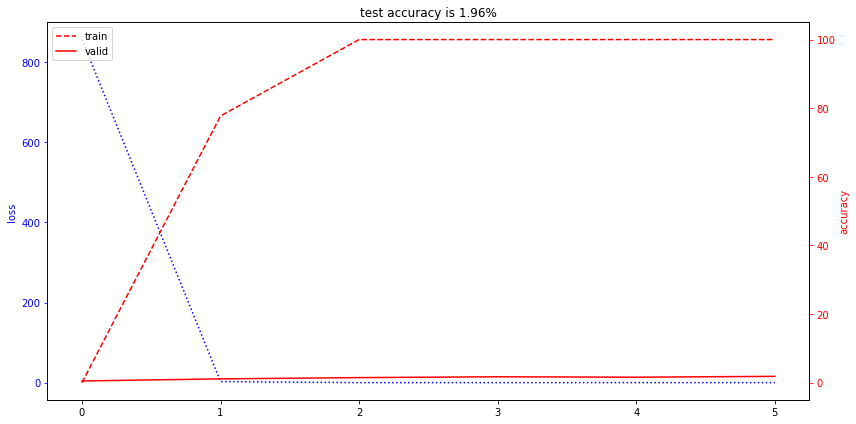

In [26]:
plot_results(losses_1, train_acc_1, valid_acc_1, test_acc_1)

The model is overfitting as the training accuracy going up and the validation accuracy is staying low.

Add regularization to the model

In [27]:
class NN1LR(NN1L):
    def __init__(self, features_size, labels_size, hidden_size, lamb_reg = 0.01):
        
        NN1L.__init__(self, features_size, labels_size, hidden_size)
        
        with self.graph.as_default():

            regularizers = (tf.nn.l2_loss(self.l1_weights) + 
                            tf.nn.l2_loss(self.l1_biases) + 
                            tf.nn.l2_loss(self.l2_weights) + 
                            tf.nn.l2_loss(self.l2_biases))
            
            self.loss += lamb_reg * regularizers
            self.optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(self.loss)

In [28]:
nn2 = NN1LR(F_train.shape[1], l_train.shape[1], 128)

In [29]:
losses_2, train_acc_2, valid_acc_2, test_acc_2 = nn2.train('nn_1lr_1', F_train, l_train, F_test, l_test)

Minibatch loss at step 0: 25782.525391
Minibatch accuracy: 1.6%
Validation accuracy: 1.2%
Minibatch loss at step 2000: 3355.937500
Minibatch accuracy: 80.9%
Validation accuracy: 2.3%
Minibatch loss at step 4000: 455.749023
Minibatch accuracy: 96.1%
Validation accuracy: 2.9%
Minibatch loss at step 6000: 64.037155
Minibatch accuracy: 96.9%
Validation accuracy: 2.9%
Minibatch loss at step 8000: 10.994190
Minibatch accuracy: 99.2%
Validation accuracy: 3.2%
Minibatch loss at step 10000: 3.798317
Minibatch accuracy: 98.0%
Validation accuracy: 3.7%


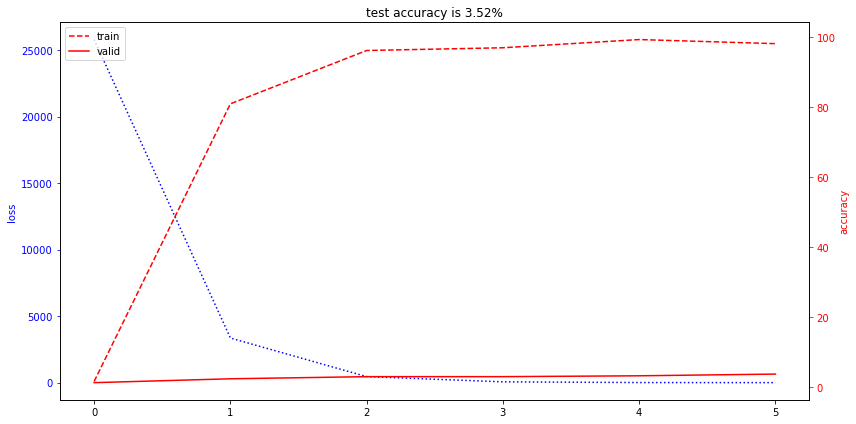

In [30]:
plot_results(losses_2, train_acc_2, valid_acc_2, test_acc_2)

Increase the regularization strength.

In [31]:
nn3 = NN1LR(F_train.shape[1], l_train.shape[1], 128, 0.1)

In [32]:
losses_3, train_acc_3, valid_acc_3, test_acc_3 = nn3.train('nn_1lr_2', F_train, l_train, F_test, l_test)

Minibatch loss at step 0: 250195.609375
Minibatch accuracy: 0.8%
Validation accuracy: 1.2%
Minibatch loss at step 2000: 4.615656
Minibatch accuracy: 4.3%
Validation accuracy: 3.4%
Minibatch loss at step 4000: 4.595106
Minibatch accuracy: 6.6%
Validation accuracy: 3.2%
Minibatch loss at step 6000: 4.656575
Minibatch accuracy: 5.9%
Validation accuracy: 3.2%
Minibatch loss at step 8000: 4.693755
Minibatch accuracy: 2.7%
Validation accuracy: 2.9%
Minibatch loss at step 10000: 4.620584
Minibatch accuracy: 3.5%
Validation accuracy: 3.1%


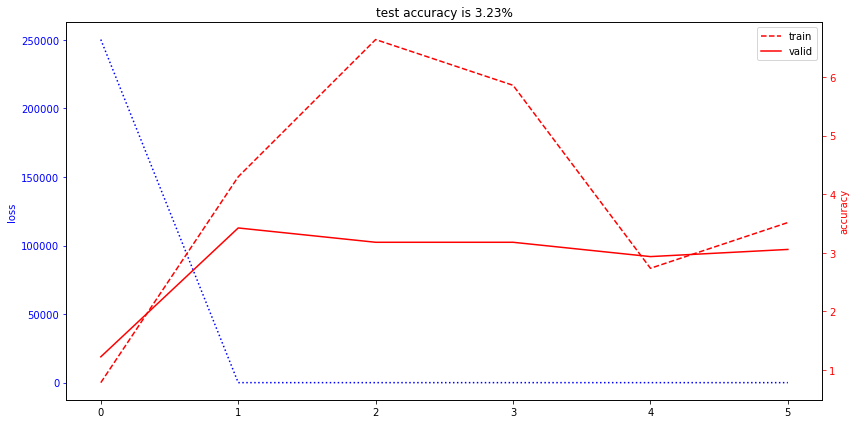

In [33]:
plot_results(losses_3, train_acc_3, valid_acc_3, test_acc_3)

With this level of regularization the model is not flexible enough.

Two layer model with regularization

In [34]:
class NN2LRD(NN):
    def __init__(self, features_size, labels_size, hidden_size1, hidden_size2, lamb_reg = 0.01):

        NN.__init__(self, features_size, labels_size)
        
        with self.graph.as_default():
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([features_size, hidden_size1], [hidden_size1])
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size1, hidden_size2], [hidden_size2])
            with tf.variable_scope("layer3"):
                self.l3_weights, self.l3_biases = self.create_layer([hidden_size2, labels_size], [labels_size])
                
            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))
            
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            regularizers = (
                tf.nn.l2_loss(self.l1_weights) + 
                tf.nn.l2_loss(self.l1_biases) + 
                tf.nn.l2_loss(self.l2_weights) + 
                tf.nn.l2_loss(self.l2_biases) + 
                tf.nn.l2_loss(self.l3_weights) + 
                tf.nn.l2_loss(self.l3_biases)
            )
            self.loss += lamb_reg * regularizers
            
            global_step = tf.Variable(0, name="globalstep")
            learning_rate = tf.train.exponential_decay(0.05, global_step, 5000, 0.97, staircase=True)
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss, global_step = global_step)

    def create_model(self, data, name):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, self.l1_weights), self.l1_biases, name="layer1")
            hidden1 = tf.nn.relu(layer1, name="relu12")
            layer2 = tf.add(tf.matmul(hidden1, self.l2_weights), self.l2_biases, name="layer2")
            hidden2 = tf.nn.relu(layer2, name="relu23")
            layer3 = tf.add(tf.matmul(hidden2, self.l3_weights), self.l3_biases, name="layer3")
            return layer3

In [35]:
nn4 = NN2LRD(F_train.shape[1], l_train.shape[1], 128, 128)

In [36]:
losses_4, train_acc_4, valid_acc_4, test_acc_4 = nn4.train('nn_2lrd', F_train, l_train, F_test, l_test)

Minibatch loss at step 0: 31930.876953
Minibatch accuracy: 0.4%
Validation accuracy: 1.3%
Minibatch loss at step 2000: 3382.725586
Minibatch accuracy: 1.2%
Validation accuracy: 0.9%
Minibatch loss at step 4000: 461.684967
Minibatch accuracy: 1.2%
Validation accuracy: 1.0%
Minibatch loss at step 6000: 68.145210
Minibatch accuracy: 7.4%
Validation accuracy: 3.9%
Minibatch loss at step 8000: 13.057003
Minibatch accuracy: 23.8%
Validation accuracy: 3.4%
Minibatch loss at step 10000: 4.350860
Minibatch accuracy: 74.6%
Validation accuracy: 1.8%


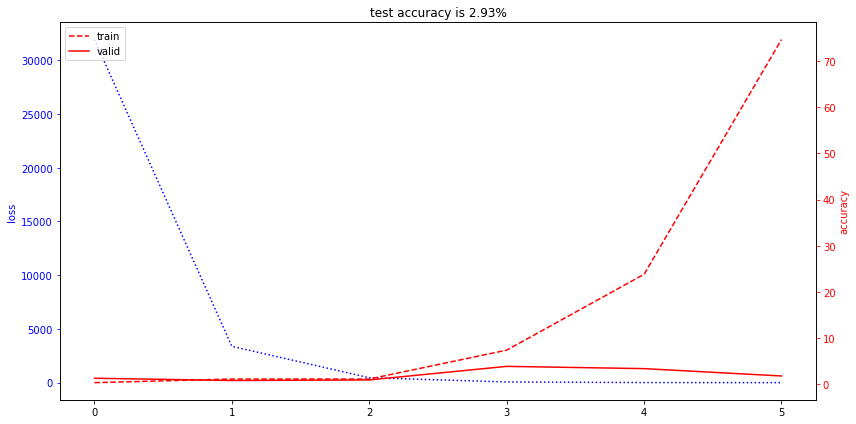

In [37]:
plot_results(losses_4, train_acc_4, valid_acc_4, test_acc_4)

I was wondering if something is wrong with the model implementation so decided to do a sanity check on the digits dataset

In [38]:
digits = load_digits()
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


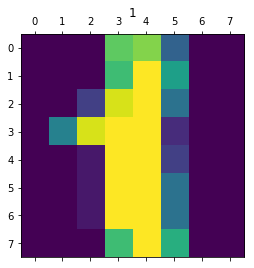

In [39]:
plt.matshow(digits.images[1]) 
plt.title(digits.target[1]) 

In [40]:
F_train1, F_test1, l_train1, l_test1 = train_test_split(
    digits.data, label_binarize(digits.target, np.unique(digits.target)), test_size = 0.25, random_state=100)

In [41]:
nn5 = NN2LRD(64, 10, 16, 16)

In [42]:
losses_5, train_acc_5, valid_acc_5, test_acc_5 = nn5.train('nn_2lrd', F_train1, l_train1, F_test1, l_test1)

Minibatch loss at step 0: 476.835022
Minibatch accuracy: 10.2%
Validation accuracy: 11.1%
Minibatch loss at step 2000: 3.535360
Minibatch accuracy: 23.0%
Validation accuracy: 20.0%
Minibatch loss at step 4000: 1.222896
Minibatch accuracy: 65.6%
Validation accuracy: 60.7%
Minibatch loss at step 6000: 1.412386
Minibatch accuracy: 54.7%
Validation accuracy: 51.9%
Minibatch loss at step 8000: 0.964866
Minibatch accuracy: 73.0%
Validation accuracy: 64.4%
Minibatch loss at step 10000: 1.158422
Minibatch accuracy: 62.1%
Validation accuracy: 59.3%


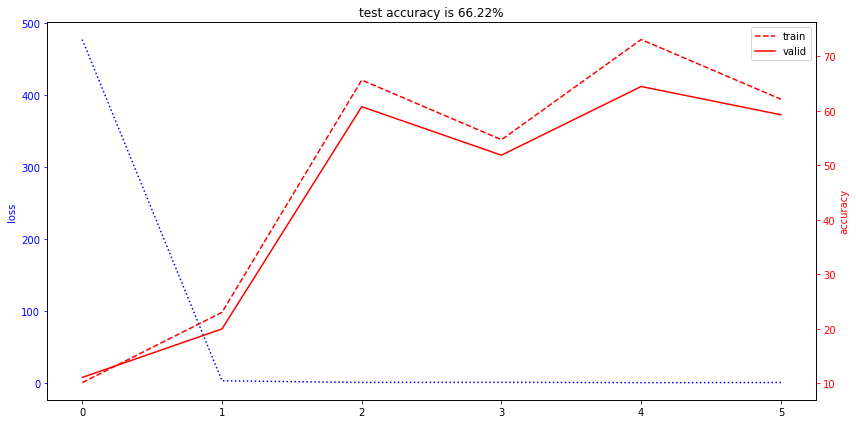

In [43]:
plot_results(losses_5, train_acc_5, valid_acc_5, test_acc_5)

It looksl like the model is OK. Lets try a better optimizer.

In [44]:
class NN2LRDA(NN2LRD):
    def __init__(self, features_size, labels_size, hidden_size1, hidden_size2, lamb_reg = 0.01):

        NN2LRD.__init__(self, features_size, labels_size, hidden_size1, hidden_size2, lamb_reg)
        
        with self.graph.as_default():
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.loss)

In [45]:
nn6 = NN2LRDA(F_train.shape[1], l_train.shape[1], 128, 128)

In [46]:
losses_6, train_acc_6, valid_acc_6, test_acc_6 = nn6.train('nn_2lrd', F_train, l_train, F_test, l_test)

Minibatch loss at step 0: 31008.039062
Minibatch accuracy: 0.4%
Validation accuracy: 1.0%
Minibatch loss at step 2000: 24742.591797
Minibatch accuracy: 7.8%
Validation accuracy: 1.5%
Minibatch loss at step 4000: 22803.294922
Minibatch accuracy: 24.2%
Validation accuracy: 1.5%
Minibatch loss at step 6000: 21015.796875
Minibatch accuracy: 44.1%
Validation accuracy: 1.7%
Minibatch loss at step 8000: 18943.498047
Minibatch accuracy: 77.0%
Validation accuracy: 1.6%
Minibatch loss at step 10000: 16385.437500
Minibatch accuracy: 89.5%
Validation accuracy: 1.7%


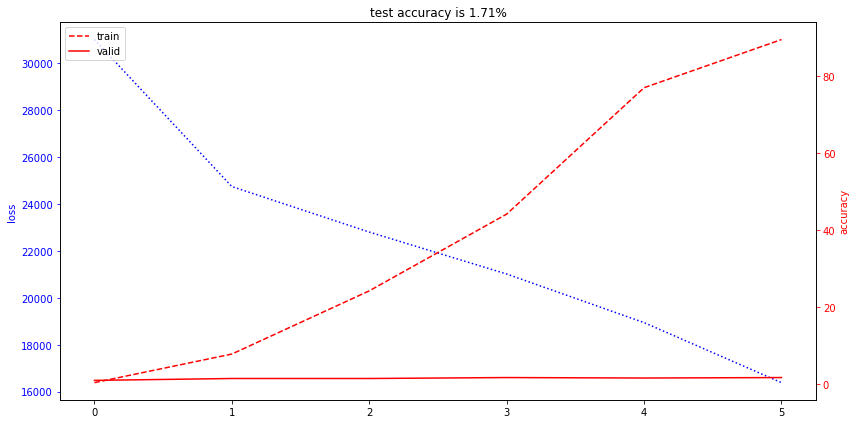

In [47]:
plot_results(losses_6, train_acc_6, valid_acc_6, test_acc_6)

Two layer model with dropouts

In [48]:
class NN2LDA(NN):

    def __init__(self, features_size, labels_size, hidden_size1, hidden_size2):

        NN.__init__(self, features_size, labels_size)
        
        with self.graph.as_default():
            
            self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
            
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([features_size, hidden_size1], [hidden_size1])
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size1, hidden_size2], [hidden_size2])
            with tf.variable_scope("layer3"):
                self.l3_weights, self.l3_biases = self.create_layer([hidden_size2, labels_size], [labels_size])
                
            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.loss)            

    def create_model(self, data, name):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, self.l1_weights), self.l1_biases, name="layer1")
            hidden1 = tf.nn.dropout(tf.nn.relu(layer1), keep_prob = self.keep_prob, name="drop12")
            
            layer2 = tf.add(tf.matmul(hidden1, self.l2_weights), self.l2_biases, name="layer2")
            hidden2 = tf.nn.dropout(tf.nn.relu(layer2), keep_prob = self.keep_prob, name="drop23")
            
            layer3 = tf.add(tf.matmul(hidden2, self.l3_weights), self.l3_biases, name="layer3")
            return layer3

    def train(
        self,name,X,y,X_test,y_test, batch_size=256, num_steps=10001,report=2000,valid_size=0.1,k_prob=1.0,verbose = 1):
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = valid_size, random_state=100)
        
        with tf.Session(graph = self.graph) as session:

            tf.global_variables_initializer().run() 

            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tensorflowlogs", session.graph)
            
            saver = tf.train.Saver()
            
            losses = []
            train_acc = []
            valid_acc = []
            test_acc = 0.0;

            for step in range(num_steps):
                X_batch, y_batch = self.get_offset(X_train, y_train, batch_size, step)

                _, loss_value, predictions = session.run(
                    fetches = [self.optimizer, self.loss, self.train_prediction],
                    feed_dict = {self.X_train : X_batch, self.y_train : y_batch, self.keep_prob : k_prob}
                )

                if (step % report == 0):
                    losses.append(loss_value)
                    train_acc.append(accuracy(predictions, y_batch))
                    valid_acc.append(
                        accuracy(
                            self.test_prediction.eval(feed_dict = {self.X_test : X_valid, self.keep_prob : 1.0}),
                            y_valid
                        )
                    )
                    
                    if (verbose > 0):
                        print('Minibatch loss at step %d: %f' % (step, loss_value))
                        print('Minibatch accuracy: %.1f%%' % train_acc[-1])
                        print('Validation accuracy: %.1f%%' % valid_acc[-1])

            test_acc = accuracy(
                self.test_prediction.eval(feed_dict = {self.X_test : X_test, self.keep_prob : 1.0}), 
                y_test
            )
            
            saver.save(session, 'models/' + name + '.ckpt') 
            
            return losses, train_acc, valid_acc, test_acc

In [55]:
nn7 = NN2LDA(F_train.shape[1], l_train.shape[1], 128, 128)

In [56]:
losses_7, train_acc_7, valid_acc_7, test_acc_7 = nn7.train('nn_2lda', F_train, l_train, F_test, l_test, k_prob = 0.7)

Minibatch loss at step 0: 8792.449219
Minibatch accuracy: 0.8%
Validation accuracy: 0.9%
Minibatch loss at step 2000: 1932.533203
Minibatch accuracy: 1.6%
Validation accuracy: 1.1%
Minibatch loss at step 4000: 338.140259
Minibatch accuracy: 1.6%
Validation accuracy: 0.5%
Minibatch loss at step 6000: 110.585907
Minibatch accuracy: 2.3%
Validation accuracy: 0.4%
Minibatch loss at step 8000: 55.786148
Minibatch accuracy: 2.7%
Validation accuracy: 0.5%
Minibatch loss at step 10000: 11.551163
Minibatch accuracy: 3.1%
Validation accuracy: 0.7%


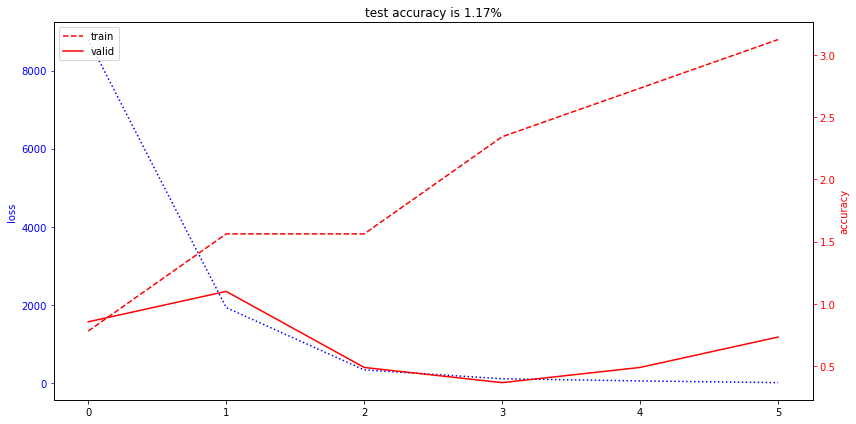

In [57]:
plot_results(losses_7, train_acc_7, valid_acc_7, test_acc_7)

Slow to rain, lets try batch normalization. It can improve the training speed and the test acuracy.

Three layer model with dropouts and batch normalization

In [58]:
class NN3LDBA(NN):

    def __init__(self, features_size, labels_size, hidden_size1, hidden_size2, hidden_size3):

        NN.__init__(self, features_size, labels_size)
        
        with self.graph.as_default():
            
            self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
            
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([features_size, hidden_size1], [hidden_size1])
                # for batch normalization
                self.beta1 = tf.Variable(tf.zeros([hidden_size1]))
                self.scale1 = tf.Variable(tf.ones([hidden_size1]))
                
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size1, hidden_size2], [hidden_size2])
                # for batch normalization
                self.beta2 = tf.Variable(tf.zeros([hidden_size2]))
                self.scale2 = tf.Variable(tf.ones([hidden_size2]))
                
            with tf.variable_scope("layer3"):
                self.l3_weights, self.l3_biases = self.create_layer([hidden_size2, hidden_size3], [hidden_size3])
                # for batch normalization
                self.beta3 = tf.Variable(tf.zeros([hidden_size3]))
                self.scale3 = tf.Variable(tf.ones([hidden_size3]))

            with tf.variable_scope("layer4"):
                self.l4_weights, self.l4_biases = self.create_layer([hidden_size3, labels_size], [labels_size])

            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)            

    def create_model(self, data, name):
        
        epsilon = 1e-3

        with tf.name_scope(name) as scope:
            
            layer1 = tf.add(tf.matmul(data, self.l1_weights), self.l1_biases, name="layer1")
            batch_mean1, batch_var1 = tf.nn.moments(layer1,[0])
            bn1 = tf.nn.batch_normalization(layer1, batch_mean1, batch_var1, self.beta1, self.scale1, epsilon)
            hidden1 = tf.nn.dropout(tf.nn.relu(bn1), keep_prob = self.keep_prob, name="drop12")
            
            layer2 = tf.add(tf.matmul(hidden1, self.l2_weights), self.l2_biases, name="layer2")
            batch_mean2, batch_var2 = tf.nn.moments(layer2,[0])
            bn2 = tf.nn.batch_normalization(layer2, batch_mean2, batch_var2, self.beta2, self.scale2, epsilon)
            hidden2 = tf.nn.dropout(tf.nn.relu(bn2), keep_prob = self.keep_prob, name="drop23")

            layer3 = tf.add(tf.matmul(hidden1, self.l3_weights), self.l3_biases, name="layer3")
            batch_mean3, batch_var3 = tf.nn.moments(layer3,[0])
            bn3 = tf.nn.batch_normalization(layer3, batch_mean3, batch_var3, self.beta3, self.scale3, epsilon)
            hidden3 = tf.nn.dropout(tf.nn.relu(bn3), keep_prob = self.keep_prob, name="drop34")

            layer4 = tf.add(tf.matmul(hidden3, self.l4_weights), self.l4_biases, name="layer4")
            return layer4

    def train(
        self,name,X,y,X_test,y_test,batch_size=256, num_steps=10001,report=2000,valid_size=0.1,k_prob=1.0,verbose = 1):

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = valid_size, random_state=100)
        
        with tf.Session(graph = self.graph) as session:

            tf.global_variables_initializer().run() 

            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tensorflowlogs", session.graph)
            
            saver = tf.train.Saver()
            
            losses = []
            train_acc = []
            valid_acc = []
            test_acc = 0.0;

            for step in range(num_steps):
                X_batch, y_batch = self.get_offset(X_train, y_train, batch_size, step)

                _, loss_value, predictions = session.run(
                    fetches = [self.optimizer, self.loss, self.train_prediction],
                    feed_dict = {self.X_train : X_batch, self.y_train : y_batch, self.keep_prob : k_prob}
                )

                if (step % report == 0):
                    losses.append(loss_value)
                    train_acc.append(accuracy(predictions, y_batch))
                    valid_acc.append(
                        accuracy(
                            self.test_prediction.eval(feed_dict = {self.X_test : X_valid, self.keep_prob : 1.0}),
                            y_valid
                        )
                    )
                    
                    if (verbose > 0):
                        print('Minibatch loss at step %d: %f' % (step, loss_value))
                        print('Minibatch accuracy: %.1f%%' % train_acc[-1])
                        print('Validation accuracy: %.1f%%' % valid_acc[-1])

            test_acc = accuracy(
                self.test_prediction.eval(feed_dict = {self.X_test : X_test, self.keep_prob : 1.0}), 
                y_test
            )
            
            saver.save(session, 'models/' + name + '.ckpt') 
            
            return losses, train_acc, valid_acc, test_acc
        
    def __predict(self, session, X, batch_size = 64):
        p = None
        sample_size = X.shape[0]
        total_batches = int(np.ceil(sample_size/batch_size))
        for batch_num in range(total_batches): 
            X_batch = X[batch_num*batch_size:(batch_num + 1)*batch_size]
            feed_dict = {self.X_test : X_batch, self.keep_prob : 1.0}
            y_batch = np.array(session.run(self.test_prediction, feed_dict))
            if(p is None):
                p = np.array(y_batch)
            else:
                p = np.vstack((p, y_batch))
        return p
            
    def predict(self, name, X, batch_size = 64):
        with tf.Session(graph = self.graph) as session:
            saver = tf.train.Saver()
            saver.restore(session, 'models/' + name + '.ckpt')
            return self.__predict(session, X, batch_size)

In [59]:
nn8 = NN3LDBA(F_train.shape[1], l_train.shape[1], 128, 128, 128)

In [60]:
losses_8, train_acc_8, valid_acc_8, test_acc_8 = nn8.train('nn_3ldba', F_train, l_train, F_test, l_test, k_prob = 0.8)

Minibatch loss at step 0: 19.324139
Minibatch accuracy: 0.4%
Validation accuracy: 0.9%
Minibatch loss at step 2000: 3.208156
Minibatch accuracy: 22.7%
Validation accuracy: 2.3%
Minibatch loss at step 4000: 1.079178
Minibatch accuracy: 71.5%
Validation accuracy: 2.3%
Minibatch loss at step 6000: 0.419024
Minibatch accuracy: 87.9%
Validation accuracy: 3.1%
Minibatch loss at step 8000: 0.326208
Minibatch accuracy: 89.8%
Validation accuracy: 2.4%
Minibatch loss at step 10000: 0.276492
Minibatch accuracy: 92.6%
Validation accuracy: 2.6%


Still it is not generalizing, I think I should draw the line here.

Load test images

In [64]:
test_ids = [ os.path.splitext(f)[0] for f in listdir('test') if isfile(join('test', f))]
test_features = load_images('test', test_ids, 224, 224)
print('Features shape ', test_features.shape)

Waiting for 24 tasks to complete...
Waiting for 20 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 7 tasks to complete...
Finished loading images...
Features shape  (10357, 224, 224)


In [65]:
test_features_mean = np.mean(test_features, axis=(0))
print(test_features_mean.shape)

(224, 224)


In [66]:
test_features_centered = test_features - test_features_mean

In [68]:
test_features_flat = test_features_centered.reshape(10357, -1)
print(test_features_flat.shape)

(10357, 50176)


In [70]:
y_pred_proba = nn8.predict('nn_3ldba', test_features_flat)

INFO:tensorflow:Restoring parameters from models/nn_3ldba.ckpt


Prepare the Kaggle submission

In [74]:
output_df = pd.DataFrame(y_pred_proba)
output_df.columns = binarizer.classes_
output_df.insert(loc=0, column='id', value=test_ids)
output_df.reset_index(drop=True, inplace=True)
output_df.to_csv('nn_pred.csv',  index=False, float_format='%.7f')